# hysteresis.ipynb

The purpose of this notebook is to perform magnetic hysteresis calculations using fields computed with the Radia magnetostatics library.

In [1]:
import pickle
from numpy import array, load
from matplotlib import pyplot as plt
from hysteresis_models import jiles_atherton, preisach
from density_functions import gaussian, gaussian_mixture
#import radia
plt.ion()

## Hysteresis curves for known model parameters

The following cells construct Jiles-Atherton & Preisach magnetic hysteresis models for a magnet with given sets of parameters and uses the models to compute and plot a hysteresis curves. Parameters can be set to obtain models for both isotropic and anisotropic magnets. If the Jiles-Atherton parameters for either the relative anisotropy contribution (`'wa'`) or the average anisotropy energy density (`'Ka'`) are not set or are set to 0, an isotropic model will be used.

In [2]:
# Define magnetizing field parameters for both models
Hlim = 4e3
dH = 10

# Define a grid of alpha/beta values & a grid density for the Preisach model
nGrid = 250
preisach_grid = -1+2*array([[a,b] for a in range(nGrid) for b in range(nGrid)])/nGrid
preisach_density = gaussian(preisach_grid, array([.5,-.5]), array([[.06,-.03],[-.03,.06]]))

# Set model parameters for grade 20 steel
ja_params = {
     'alpha': 4.93e-4,
     'a': 399,
     'Ms': 1.35e6,
     'k': 300,
     'c': 0.120,
     'wa': 0,
     'Ka': 0,
     'psi': 0,
}
pr_params = {
    'Ms': 1.2e6,
    'grid': Hlim*preisach_grid,
    'density': preisach_density, #load("Models/pr100-density.npy")
}

# You can also easily load model parameter dictionaries using pickle:
# ja_params = pickle.load("Models/g20steel_ja.pickle")
# pr_params = pickle.load("Models/g20steel_pr.pickle")

# Set hysteresis calculation options
ja_opts = {
    'integrator': 'EULER',
    'H_lim': Hlim,
    'dH': 10,
}
pr_opts = {
    'H_lim': Hlim,
    'dH': 10,
}

# Construct a Jiles-Atherton model & compute its hysteresis
jaModel = jiles_atherton(**ja_params)
jaH, jaB = jaModel.get_hysteresis(**ja_opts)

# Construct a Preisach model & compute its hysteresis
prModel = preisach(**pr_params)
prH, prB = prModel.get_hysteresis(**pr_opts)

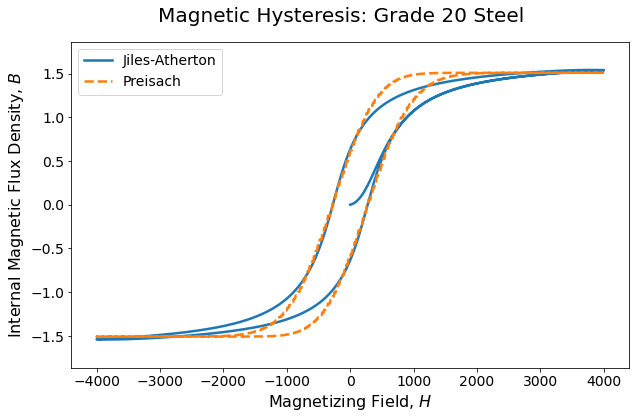

In [3]:
# Plot hysteresis curves for both models
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"Magnetic Hysteresis: Grade 20 Steel",fontsize=20,y=.96)
ax.plot(jaH,jaB,lw=2.5,label=r"Jiles-Atherton")
ax.plot(prH,prB,lw=2.5,label=r"Preisach",ls='--')
ax.legend(fontsize=14)
ax.axis(1.1*array([-ja_opts['H_lim'],ja_opts['H_lim'],1.1*jaB.min(),1.1*jaB.max()]))
ax.set_xlabel(r"Magnetizing Field, $H$",fontsize=16)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B$",fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig("Images/Grade-20-Steel_Hysteresis.png",dpi=300,bbox_inches='tight',facecolor='white',transparent=False)

## Fitting hysteresis model parameters using Radia field solver

The remaining cells demonstrate the use of fields computed using the Radia field solver library to perform magnetic hysteresis calculations and parameter estimation for Jiles-Atherton & Preisach models of magnetic hystereis for magnets of various geometries and designs.

In [22]:
# TODO: integrate with Radia field calculations